# <font color='blue'>Weber Souza</font>
# <font color='blue'>Deep Learning Para Aplicações de IA com PyTorch e Lightning</font>

## <font color='blue'>Lab 3 - Modelagem</font>
### <font color='blue'>Análise de Imagens de Satélite com Torchvision Para Demonstrar a Importância da Função de Ativação</font>

![title](imagens/Lab3.png)

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.11.7


In [ ]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [ ]:
!pip install -q torch

In [ ]:
!pip install -q torchvision

In [2]:
# Imports
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models
import gc
import types
import pkg_resources
import pytorch_lightning as pl
from sklearn import metrics
%matplotlib inline

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Weber Souza" --iversions

Author: Weber Souza

torch            : 2.2.1
sklearn          : 1.2.2
matplotlib       : 3.8.0
numpy            : 1.26.4
pytorch_lightning: 2.2.1
torchvision      : 0.17.1



## Verificando o Ambiente de Desenvolvimento

In [4]:
# Relatório completo

# Verificando o dispositivo
processing_device = "cuda" if torch.cuda.is_available() else "cpu"

# Verificando se GPU pode ser usada (isso depende da plataforma CUDA estar instalada)
torch_aval = torch.cuda.is_available()

# Labels para o relatório de verificação
lable_1 = 'Visão Geral do Ambiente'
lable_2 = 'Se NVIDIA-SMI não for encontrado, então CUDA não está disponível'
lable_3 = 'Fim da Checagem'

# Função para verificar o que está importado nesta sessão
def get_imports():

    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):            
            name = val.__module__.split(".")[0]

        poorly_named_packages = {"PIL": "Pillow", "sklearn": "scikit-learn"}

        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

# Imports nesta sessão
imports = list(set(get_imports()))

# Loop para verificar os requerimentos
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
        
# Pasta com os dados (quando necessário)
pasta_dados = r'dados'

print(f'{lable_1:-^100}')
print()
print(f"Device:", processing_device)
print(f"Pasta de Dados: ", pasta_dados)
print(f"Versões dos Pacotes Requeridos: ", requirements)
print(f"Dispositivo Que Será Usado Para Treinar o Modelo: ", processing_device)
print(f"CUDA Está Disponível? ", torch_aval)
print("Versão do PyTorch: ", torch.__version__)
print("Versão do Lightning: ", pl.__version__)
print()
print(f'{lable_2:-^100}\n')
!nvidia-smi
gc.collect()
print()
print(f"Limpando a Memória da GPU (se disponível): ", torch.cuda.empty_cache())
print(f'\n{lable_3:-^100}')

--------------------------------------Visão Geral do Ambiente---------------------------------------

Device: cpu
Pasta de Dados:  dados
Versões dos Pacotes Requeridos:  [('matplotlib', '3.8.0'), ('numpy', '1.26.4'), ('scikit-learn', '1.2.2'), ('torch', '2.2.1'), ('torchvision', '0.17.1')]
Dispositivo Que Será Usado Para Treinar o Modelo:  cpu
CUDA Está Disponível?  False
Versão do PyTorch:  2.2.1+cpu
Versão do Lightning:  2.2.1

------------------Se NVIDIA-SMI não for encontrado, então CUDA não está disponível------------------

Wed Mar 27 11:10:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.33                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-U

## Transformações

In [5]:
# Define os hiperparâmetros
batch_size = 32
num_epochs = 5
learning_rate = 0.0003

In [6]:
# Define as Transformações # Transform é um pacote do torcvision para modificar imagens
transform = transforms.Compose([transforms.RandomHorizontalFlip(),       #Rotaciona a imagem
                                transforms.ToTensor(),                   
                                transforms.Resize((100,100)),            # Muda o tamanho das imagens
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                     std = [0.229, 0.224, 0.225])]) 

## Divisão dos Dados

In [7]:
dataset_treino = datasets.ImageFolder('dados/treino', transform = transform) 

In [8]:
dataset_valid = datasets.ImageFolder('dados/val', transform = transform) 

In [9]:
dataset_teste = datasets.ImageFolder('dados/teste', transform = transform) 

In [10]:
print(f"Número Total de Imagens de Treino: {len(dataset_treino)}")
print(f"Número Total de Imagens de Validação: {len(dataset_valid)}")
print(f"Número Total de Imagens de Teste: {len(dataset_teste)}") 

Número Total de Imagens de Treino: 5581
Número Total de Imagens de Validação: 2716
Número Total de Imagens de Teste: 2643


> Agora preparamos os dataloaders.

In [11]:
# Dataloader de treino
dataloader_treino = DataLoader(dataset_treino, batch_size = batch_size, shuffle = True)

In [12]:
# Dataloader de validação
dataloader_valid = DataLoader(dataset_valid, batch_size = batch_size, shuffle = True)

In [13]:
# Dataloader de teste
dataloader_teste = DataLoader(dataset_teste, batch_size = batch_size, shuffle = False)

> Vamos visualizar a distribuição das classes de imagens.

In [14]:
# Nomes das classes
nomes_classes = os.listdir('dados/treino')

In [15]:
nomes_classes

['cloudy', 'desert', 'green_area', 'water']

In [16]:
# Loop para contar as imagens em cada classe
image_count = {}
for i in nomes_classes:
    image_count[i] = len(os.listdir(os.path.join('dados/treino',i))) - 1

In [17]:
image_count

{'cloudy': 1489, 'desert': 1118, 'green_area': 1479, 'water': 1491}

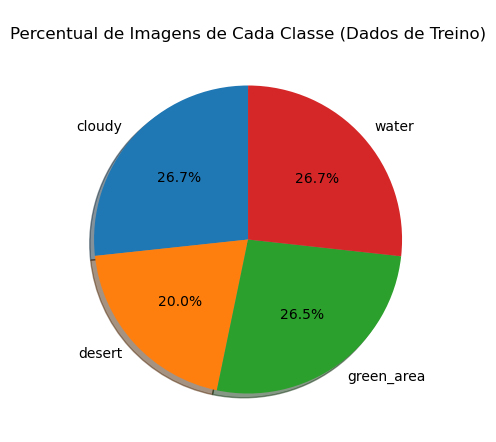

{'cloudy': 1489, 'desert': 1118, 'green_area': 1479, 'water': 1491}


In [18]:
# Plot
fig1, ax1 = plt.subplots(figsize = (5, 5), subplot_kw = dict(aspect = "equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow = True,
        textprops = dict(color = "black"),
        autopct = '%1.1f%%',
        startangle = 90)
plt.title("\nPercentual de Imagens de Cada Classe (Dados de Treino)", color = 'black')
plt.show()
print(image_count)

## Modelagem

In [19]:
# Baixamos o modelo pré-treinado de arquitetura DenseNet, incluindo os pesos
modelo = models.densenet121(weights = 'DEFAULT')

In [20]:
# Carregamos os parâmetros (pesos) do modelo
modelo.parameters()

<generator object Module.parameters at 0x0000024423CB9700>

Se require_grad for definido como False, você está congelando parte do modelo, pois nenhuma alteração ocorre em seus parâmetros. 

Definimos requer_grad como verdadeiro se os gradientes precisam ser calculados, caso contrário, definimos como falso. 

In [21]:
# "Congelamos" os pesos do modelo
for param in modelo.parameters():
    param.require_grad = False

### O Papel da Função de Ativação no Modelo de Deep Learning

![DSA](imagens/cnn-arquitetura1.jpeg)

Um componente pequeno, mas importante nesse processo, é a Função de Ativação, sendo a Unidade Linear Retificada ou ReLU a mais usada em Deep Learning atualmente. 

A matemática também é muito simples - onde quer que um número negativo ocorra, troque-o por um 0. Isso ajuda o modelo a manter-se matematicamente saudável, evitando que os valores aprendidos fiquem presos perto de 0 ou explodam em direção ao infinito. É a "graxa de eixo" das CNNs - não particularmente fascinante, mas sem ela as redes não vão muito longe.

A função de ativação é um nó que é colocado no final ou entre as camadas. A função de ativação é a transformação não linear que fazemos sobre o sinal de entrada. Essa saída transformada é então enviada para a próxima camada de neurônios como entrada.

![DSA](imagens/act-func.png)

Temos diferentes tipos de funções de ativação, sendo a Unidade Linear Retificada (ReLU) a mais comum em CNNs.

Uma das maiores vantagens da ReLU em relação a outras funções de ativação é que ela não ativa todos os neurônios ao mesmo tempo. Na imagem da função ReLU acima, notamos que ela converte todas as entradas negativas em zero e o neurônio não é ativado. Isso a torna muito eficiente em termos computacionais, pois poucos neurônios são ativados por vez. Não satura na região positiva. Na prática, a ReLU pode convergir seis vezes mais rápido que as funções de ativação tanh e sigmóide.

Algumas desvantagens que ReLU apresenta é que ela está saturada na região negativa, significando que o gradiente nessa região é zero. Com o gradiente igual a zero, durante a retropropagação, todos os pesos não serão atualizados; para corrigir isso, podemos usar a Leaky ReLU. Além disso, as funções ReLU não são centralizadas em zero. Isso significa que, para chegar ao seu ponto ideal, ela precisará usar um caminho em zig-zag que pode ser mais longo.

Embora a ReLU seja normalmente a opção ideal em muitos casos, podemos testar outras opções a fim de tentar encontrar a melhor performance possível.

### Camada de Classificação com Função de Ativação LeakyReLU

https://arxiv.org/pdf/1505.00853.pdf

Leaky ReLU tem uma pequena inclinação para valores negativos, em vez de zero: y = 0,01x quando x < 0.


In [22]:
# Arquitetura do classificador ("cabeça" do modelo) com LeakyReLU
#clf = nn.Sequential(nn.Linear(1024,460),
#                    nn.LeakyReLU(0.1),
#                    nn.Dropout(0.4),
#                    nn.Linear(460, 5)
#)

### Camada de Classificação com Função de Ativação ELU (Exponential Linear)

https://arxiv.org/pdf/1511.07289.pdf

Semelhante à Leaky ReLU, a ELU tem uma pequena inclinação para valores negativos. Em vez de uma linha reta, ela é projetada para combinar as partes boas da ReLU e da LeakyReLU.

In [23]:
# Arquitetura do classificador ("cabeça" do modelo) ELU
#clf = nn.Sequential(nn.Linear(1024,460),
#                    nn.ELU(),
#                    nn.Dropout(0.4),
#                    nn.Linear(460, 5)
#)

### Camada de Classificação com Função de Ativação ReLU

https://arxiv.org/pdf/1803.08375.pdf

É a função de ativação mais usada atualmente em Deep Learning e uma das mais simples, embora possa apresentar problemas.

In [24]:
# Arquitetura do classificador ("cabeça" do modelo) com ReLu
clf = nn.Sequential(nn.Linear(1024,460),
                    nn.ReLU(),
                    nn.Dropout(0.4),
                    nn.Linear(460, 5)
)

In [25]:
# Adiciona a camada de classificação ao modelo pré-treinado (vamos treinar somente a última camada)
modelo.classifier = clf

In [26]:
"""Se disponível usamos GPU. Caso contrário usamos CPU."""
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [27]:
device = get_default_device()

In [28]:
print(device)

cpu


In [29]:
# Envia o modelo para a memória do device
modelo.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [30]:
# Função de perda
criterion = nn.CrossEntropyLoss()

In [31]:
# Otimizador
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [32]:
%%time

# Vamos medir o tempo de execução
total_step = len(dataloader_treino)
print_every = len(dataloader_treino) - 1
loss_values = []
total_step = len(dataloader_treino)
epoch_times = []

# Loop de treinamento pelo número de épocas
for epoch in range(num_epochs):
    
    # Loop por cada batch de imagem/label
    for i, (images, labels) in enumerate(dataloader_treino): 
        
        # Zera o contador de erro
        running_loss = 0.0
        
        # Carrega imagens do batch
        images = images.to(device)
        
        # Carrega labels do batch
        labels = labels.to(device)
        
        # Faz a previsão com o modelo
        outputs = modelo(images)
        
        # Calcula o erro do modelo
        loss = criterion(outputs, labels)
        
        # Zera os gradientes que serão aprendidos
        optimizer.zero_grad()
        
        # Aplica o backpropagation
        loss.backward()
        
        # Aplica a otimização dos gradientes (aqui ocorre o aprendizado)
        optimizer.step()
        
        # Registra o erro do modelo
        running_loss += loss.item() 
        
        # Imprime em intervalos regulares
        if (i+1) % print_every == 0:
            
            loss_values.append(running_loss / print_every)
            
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}: Batch Loss : {}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), running_loss / print_every))
            
            running_loss = 0

Epoch [1/5], Step [174/175], Loss: 0.0585: Batch Loss : 0.0003361671349440498
Epoch [2/5], Step [174/175], Loss: 0.0025: Batch Loss : 1.4450197675447355e-05
Epoch [3/5], Step [174/175], Loss: 0.0449: Batch Loss : 0.00025827193568492756
Epoch [4/5], Step [174/175], Loss: 0.0023: Batch Loss : 1.2946958739267683e-05
Epoch [5/5], Step [174/175], Loss: 0.1870: Batch Loss : 0.0010745689786713698
CPU times: total: 1h 2min 50s
Wall time: 32min 23s


## Avaliação do Modelo

In [33]:
# Cria os arrays que vão receber as previsões
arr_pred = np.empty((0,len(dataset_teste)), int)
arr_label = np.empty((0,len(dataset_teste)), int)

In [34]:
# Loop de previsões
with torch.no_grad(): 
    
    # Contadores
    correct = 0
    total = 0
    
    # Loop pelos dados de teste
    for images, labels in dataloader_teste: 
        
        # Extrai imagens e labels do batch de teste
        images = images.to(device)
        labels = labels.to(device)
        
        # Previsão com o modelo
        outputs = modelo(images)
        
        # Extrai o maior valor de probabilidade (classe prevista)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred = predicted.cpu().numpy()
        lb = labels.cpu().numpy()
        arr_pred = np.append(arr_pred, pred)
        arr_label = np.append(arr_label, lb)
        
    print('Acurácia do Modelo em ' + str(len(dataset_teste)) + ' imagens de teste: {} %'.format(100 * correct/total))

Acurácia do Modelo em 2643 imagens de teste: 34.96027241770715 %


> Acurácia Usando Função de Ativação LeakyReLU: 31.83431952662722 % em 1min 37s

> Acurácia Usando Função de Ativação ELU: 37.15976331360947 % em Wall time: 1min 32s

> Acurácia Usando Função de Ativação ReLU: 32.18934911242604 % em Wall time: 1min 34s

In [35]:
# Função para o plot da matriz de confusão
def plot_confusion_matrix(cm,
                          target_names,
                          title = 'Matriz de Confusão',
                          cmap = None,
                          normalize = True):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize = (10, 8))
    plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
        
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Label Real')
    plt.xlabel('Label Previsto\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [36]:
print(metrics.classification_report(arr_label, arr_pred))

              precision    recall  f1-score   support

           0       0.38      0.33      0.35       715
           1       0.29      0.27      0.28       523
           2       0.35      0.27      0.31       700
           3       0.36      0.50      0.42       705

    accuracy                           0.35      2643
   macro avg       0.34      0.34      0.34      2643
weighted avg       0.35      0.35      0.34      2643



In [37]:
from sklearn import metrics

In [38]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

torch            : 2.2.1
sklearn          : 1.2.2
matplotlib       : 3.8.0
numpy            : 1.26.4
pytorch_lightning: 2.2.1
torchvision      : 0.17.1



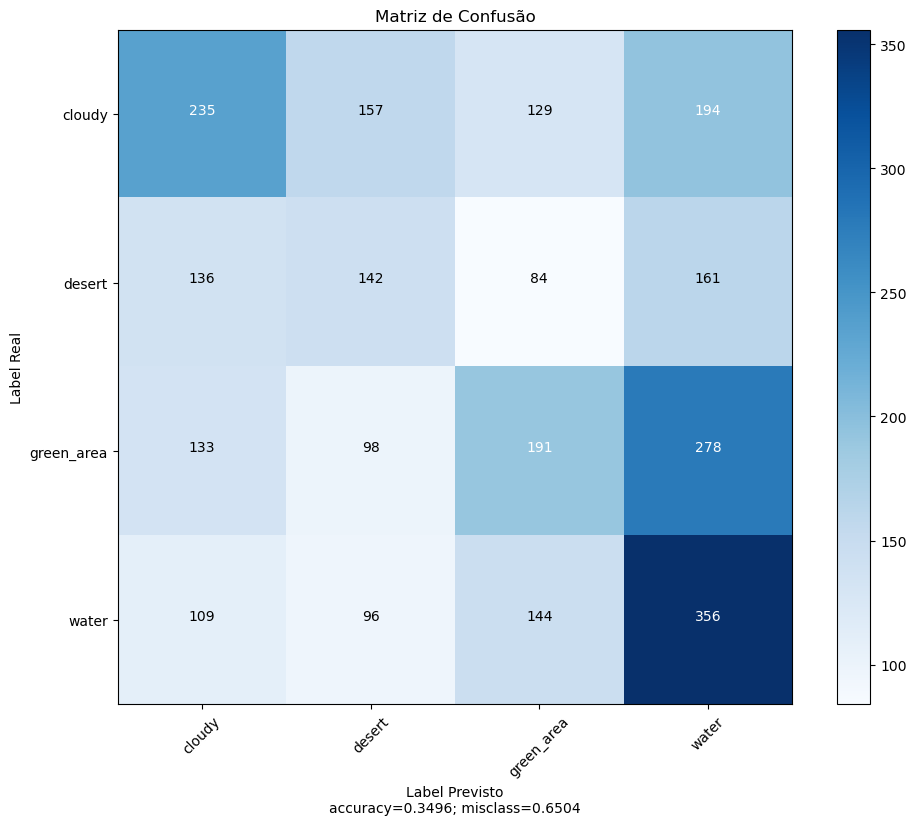

In [39]:
# Matriz de Confusão
cm = metrics.confusion_matrix(arr_label, arr_pred)
plot_confusion_matrix(cm, target_names = nomes_classes, title = 'Matriz de Confusão' , normalize = False)

# Fim